In [1]:
pip install keras==2.9.0

In [2]:
### Let's read a sample audio using librosa
import librosa
audio_file_path='UrbanSound8K/100263-2-0-3.wav'
librosa_audio_data,librosa_sample_rate=librosa.load(audio_file_path)

In [3]:
print(librosa_audio_data)

[ 0.00330576  0.00468387  0.00360455 ... -0.0037562  -0.00348641
 -0.00356705]


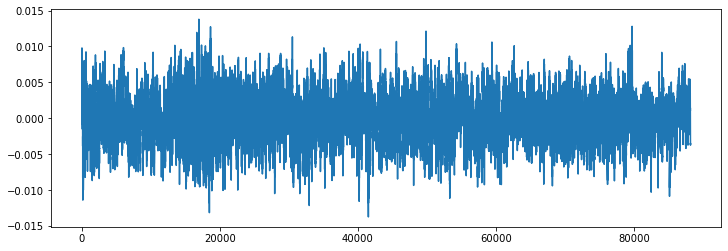

In [4]:
### Lets plot the librosa audio data
import matplotlib.pyplot as plt
# Original audio with 1 channel 
plt.figure(figsize=(12, 4))
plt.plot(librosa_audio_data)

## Observation
#### Here Librosa converts the signal to mono, meaning the channel will always be 1

In [5]:
### Lets read with scipy
from scipy.io import wavfile as wav
wave_sample_rate, wave_audio = wav.read(audio_file_path) 

In [6]:
wave_audio

array([[ 194,  100],
       [ 179,  113],
       [ 160,  124],
       ...,
       [-143,  -87],
       [-134,  -91],
       [-110,  -98]], dtype=int16)

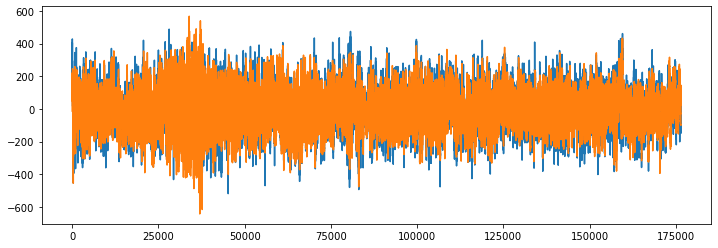

In [7]:
import matplotlib.pyplot as plt

# Original audio with 2 channels 
plt.figure(figsize=(12, 4))
plt.plot(wave_audio)

## Extract Features
#### Here we will be using Mel-Frequency Cepstral Coefficients(MFCC) from the audio samples. The MFCC summarises the frequency distribution across the window size, so it is possible to analyse both the frequency and time characteristics of the sound. These audio representations will allow us to identify features for classification.

In [8]:
mfccs = librosa.feature.mfcc(y=librosa_audio_data, sr=librosa_sample_rate, n_mfcc=40)
print(mfccs.shape)

(40, 173)


In [9]:
mfccs

array([[-4.75309448e+02, -4.51539337e+02, -4.49755127e+02, ...,
        -4.77412781e+02, -4.73848846e+02, -4.91058777e+02],
       [ 1.15936340e+02,  1.12366516e+02,  1.12244164e+02, ...,
         1.12045395e+02,  1.11286507e+02,  1.03281311e+02],
       [-1.89592590e+01, -2.56048889e+01, -3.12500191e+01, ...,
        -9.15441895e+00, -9.77182007e+00, -4.79179811e+00],
       ...,
       [-2.60460019e+00, -2.85800576e+00, -4.48165464e+00, ...,
        -1.90692663e-01,  3.74826145e+00,  7.53867531e+00],
       [-6.84984744e-01, -9.56209779e-01, -1.20930243e+00, ...,
        -1.23640537e-01,  6.06250286e-01,  2.67598414e+00],
       [-9.39640403e-01,  1.04388189e+00,  6.72155571e+00, ...,
        -2.33736587e+00, -4.64974403e+00, -3.15545964e+00]], dtype=float32)

In [10]:
#### Extracting MFCC's For every audio file
import pandas as pd
import os
import librosa

audio_dataset_path='UrbanSound8K/audio/'
metadata=pd.read_csv('UrbanSound8K/metadata/UrbanSound8K.csv')
metadata.head()

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [11]:
def features_extractor(file):
    audio, sample_rate = librosa.load(file_name, res_type='kaiser_fast') 
    mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
    mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)
    
    return mfccs_scaled_features
    

In [12]:
import numpy as np
from tqdm import tqdm
### Now we iterate through every audio file and extract features 
### using Mel-Frequency Cepstral Coefficients
extracted_features=[]
for index_num,row in tqdm(metadata.iterrows()):
    file_name = os.path.join(os.path.abspath(audio_dataset_path),'fold'+str(row["fold"])+'/',str(row["slice_file_name"]))
    final_class_labels=row["class"]
    data=features_extractor(file_name)
    extracted_features.append([data,final_class_labels])

3554it [03:09, 19.28it/s]C:\Users\Aayush Srivastava\anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1323
  return f(*args, **kwargs)
8324it [07:13, 23.02it/s]C:\Users\Aayush Srivastava\anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1103
  return f(*args, **kwargs)
8329it [07:13, 29.61it/s]C:\Users\Aayush Srivastava\anaconda3\lib\site-packages\librosa\util\decorators.py:88: UserWarning: n_fft=2048 is too small for input signal of length=1523
  return f(*args, **kwargs)
8732it [07:34, 19.23it/s]


In [13]:
### converting extracted_features to Pandas dataframe
extracted_features_df=pd.DataFrame(extracted_features,columns=['feature','class'])
extracted_features_df.head()

,feature,class
0,"[-218.18938, 71.38549, -131.49442, -52.25892, ...",dog_bark
1,"[-425.05234, 110.67095, -54.192833, 62.045406,...",children_playing
2,"[-459.82623, 122.82864, -47.908062, 53.302677,...",children_playing
3,"[-414.82184, 102.94826, -36.65685, 54.170742, ...",children_playing
4,"[-447.60776, 115.08627, -53.74607, 61.55309, 1...",children_playing


In [14]:
### Split the dataset into independent and dependent dataset
X=np.array(extracted_features_df['feature'].tolist())
y=np.array(extracted_features_df['class'].tolist())

In [15]:
X.shape

(8732, 40)

In [16]:
y

array(['dog_bark', 'children_playing', 'children_playing', ...,
       'car_horn', 'car_horn', 'car_horn'], dtype='<U16')

In [17]:
### Label Encoding
###y=np.array(pd.get_dummies(y))
### Label Encoder
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
labelencoder=LabelEncoder()
y=to_categorical(labelencoder.fit_transform(y))

In [18]:
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [19]:
### Train Test Split
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,y,test_size=0.2,random_state=0)

In [20]:
X_train

array([[-1.3211458e+02,  1.1391494e+02, -2.3927406e+01, ...,
         3.3260243e+00, -1.4790288e+00,  2.8912871e+00],
       [-1.4296137e+01,  9.1951004e+01, -8.6025953e+00, ...,
        -3.3708370e+00, -5.2008624e+00, -1.5975088e+00],
       [-4.9827820e+01,  1.8449357e-01, -2.0364500e+01, ...,
         2.0259936e+00, -8.3159244e-01,  2.7930872e+00],
       ...,
       [-4.2723694e+02,  9.2938095e+01,  2.8287885e+00, ...,
         8.1411356e-01,  6.6066748e-01,  7.8365982e-01],
       [-1.4640692e+02,  1.3716916e+02, -3.4362492e+01, ...,
         1.3839475e+00, -1.9667517e+00, -8.8792086e-01],
       [-4.2171307e+02,  2.1160454e+02,  2.5852380e+00, ...,
        -5.1338639e+00, -3.6135261e+00, -1.3413877e+00]], dtype=float32)

In [21]:
y

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

In [22]:
X_train.shape

(6985, 40)

In [23]:
X_test.shape

(1747, 40)

In [24]:
y_train.shape

(6985, 10)

In [25]:
y_test.shape

(1747, 10)

# MODEL CREATION

In [26]:
import tensorflow as tf
print(tf.__version__)

2.9.1


In [27]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Dropout,Activation,Flatten
from tensorflow.keras.optimizers import Adam
from sklearn import metrics

In [28]:
### No of classes
num_labels=y.shape[1]

In [29]:
model=Sequential()
###first layer
model.add(Dense(100,input_shape=(40,)))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###second layer
model.add(Dense(200))
model.add(Activation('relu'))
model.add(Dropout(0.5))
###third layer
model.add(Dense(100))
model.add(Activation('relu'))
model.add(Dropout(0.5))

###final layer
model.add(Dense(num_labels))
model.add(Activation('sigmoid'))

In [30]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 100)               4100      
                                                                 
 activation (Activation)     (None, 100)               0         
                                                                 
 dropout (Dropout)           (None, 100)               0         
                                                                 
 dense_1 (Dense)             (None, 200)               20200     
                                                                 
 activation_1 (Activation)   (None, 200)               0         
                                                                 
 dropout_1 (Dropout)         (None, 200)               0         
                                                                 
 dense_2 (Dense)             (None, 100)               2

In [31]:
model.compile(loss='categorical_crossentropy',metrics=['accuracy'],optimizer='adam')

In [32]:
## Trianing my model
from tensorflow.keras.callbacks import ModelCheckpoint
from datetime import datetime 

num_epochs = 100
num_batch_size = 32

checkpointer = ModelCheckpoint(filepath='saved_models/audio_classification.hdf5', 
                               verbose=1, save_best_only=True)
start = datetime.now()

model.fit(X_train, y_train, batch_size=num_batch_size, epochs=num_epochs, validation_data=(X_test, y_test), callbacks=[checkpointer], verbose=1)


duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/100
203/219 [==========================>...] - ETA: 0s - loss: 9.0490 - accuracy: 0.1244
Epoch 1: val_loss improved from inf to 2.29067, saving model to saved_models\audio_classification.hdf5
219/219 [==============================] - 2s 5ms/step - loss: 8.6052 - accuracy: 0.1253 - val_loss: 2.2907 - val_accuracy: 0.1082
Epoch 2/100
206/219 [===========================>..] - ETA: 0s - loss: 2.5025 - accuracy: 0.1364
Epoch 2: val_loss improved from 2.29067 to 2.28151, saving model to saved_models\audio_classification.hdf5
219/219 [==============================] - 1s 3ms/step - loss: 2.4932 - accuracy: 0.1374 - val_loss: 2.2815 - val_accuracy: 0.1179
Epoch 3/100
202/219 [==========================>...] - ETA: 0s - loss: 2.3260 - accuracy: 0.1428
Epoch 3: val_loss improved from 2.28151 to 2.25982, saving model to saved_models\audio_classification.hdf5
219/219 [==============================] - 1s 3ms/step - loss: 2.3210 - accuracy: 0.1457 - val_loss: 2.2598 - val_accuracy: 0.1706

In [33]:
test_accuracy=model.evaluate(X_test,y_test,verbose=0)
print(test_accuracy[1])

0.7389811277389526


In [34]:
filename="UrbanSound8K/dog_bark.wav"
prediction_feature=features_extractor(filename)
prediction_feature=prediction_feature.reshape(1,-1)
model.predict(prediction_feature)

1/1 [==============================] - 0s 176ms/step


array([[0.04260195, 0.9836603 , 0.5108976 , 0.8547827 , 0.75209075,
        0.2696489 , 0.07672592, 0.05616597, 0.09821802, 0.99098253]],
      dtype=float32)

In [35]:
prediction_feature.shape

(1, 40)

In [36]:
X_test[1]

array([-466.47327   ,    1.501665  ,  -34.40004   ,   35.6894    ,
        -15.182925  ,  -18.883924  ,   -0.7577297 ,  -16.02822   ,
        -21.365473  ,    7.6201305 ,  -29.034496  ,  -19.153774  ,
         -2.6873193 ,   -8.493192  ,  -14.771136  ,   -7.0288925 ,
         -7.1169443 ,    8.868939  ,   14.91199   ,   21.457466  ,
         21.327414  ,    0.88716316,  -18.810377  ,   -5.0179625 ,
         -0.70585895,    2.9008534 ,   -6.711027  ,  -16.649858  ,
         -9.8316965 ,   12.847431  ,    0.6619251 ,  -23.943695  ,
        -15.194154  ,    9.193658  ,   10.399717  ,   -0.5999181 ,
         -1.2594264 ,   17.706207  ,   13.831076  ,   -5.1632876 ],
      dtype=float32)

In [37]:
model.predict(X_test)

55/55 [==============================] - 0s 1ms/step


array([[8.6196852e-01, 5.0018609e-01, 9.2042321e-01, ..., 9.1263198e-04,
        6.1608803e-01, 9.3391091e-01],
       [4.3145228e-02, 6.8860996e-01, 7.5464255e-01, ..., 1.0859852e-03,
        2.1920843e-01, 8.7786353e-01],
       [1.3516767e-02, 8.6462349e-01, 1.6229920e-01, ..., 7.8128135e-01,
        1.0315184e-01, 6.4496040e-01],
       ...,
       [3.7673339e-01, 9.9989021e-01, 3.3061680e-01, ..., 8.3223631e-06,
        5.0092325e-02, 9.9896640e-01],
       [5.1065212e-01, 2.6448449e-01, 8.0037606e-01, ..., 2.9751778e-01,
        1.8487917e-01, 8.4215558e-01],
       [8.0434108e-01, 1.9040670e-01, 7.7394247e-01, ..., 2.5003830e-01,
        3.6401328e-01, 7.2489351e-01]], dtype=float32)

## Testing Some Test Audio Data
#### Steps:

#### -Preprocess the new audio data
#### -predict the classes


In [38]:
filename="UrbanSound8K/6988-5-0-3.wav"
audio, sample_rate = librosa.load(filename, res_type='kaiser_fast') 
mfccs_features = librosa.feature.mfcc(y=audio, sr=sample_rate, n_mfcc=40)
mfccs_scaled_features = np.mean(mfccs_features.T,axis=0)

print(mfccs_scaled_features)
mfccs_scaled_features=mfccs_scaled_features.reshape(1,-1)
print(mfccs_scaled_features)
print(mfccs_scaled_features.shape)
predicted_label=model.predict(mfccs_scaled_features)
predicted_label = np.squeeze(predicted_label)
print(predicted_label)
np.max(predicted_label)
np.argmax(predicted_label)

[-103.89733     165.23088     -39.72623      31.878206      1.3944257
   22.563684      6.715859     15.421699      5.7869506    17.056995
   -5.246336     13.625031      1.5033606     3.7725604     0.44050688
    3.854563     -1.185818      2.9685948     5.5152645     3.679133
    4.3335795     4.8206882     3.7529268     2.4499176     7.33352
    5.570742      8.070612      6.7572656     6.6295714     4.8474255
    2.8680885     0.19144519    2.5216243     1.9769777     2.3174179
    3.435427      6.9347186     2.590403      3.276835      1.6340346 ]
[[-103.89733     165.23088     -39.72623      31.878206      1.3944257
    22.563684      6.715859     15.421699      5.7869506    17.056995
    -5.246336     13.625031      1.5033606     3.7725604     0.44050688
     3.854563     -1.185818      2.9685948     5.5152645     3.679133
     4.3335795     4.8206882     3.7529268     2.4499176     7.33352
     5.570742      8.070612      6.7572656     6.6295714     4.8474255
     2.8680885    

5

## A numeric identifier of the sound class: 
#### 0 = air_conditioner
#### 1 = car_horn
#### 2 = children_playing
#### 3 = dog_bark
#### 4 = drilling
#### 5 = engine_idling
#### 6 = gun_shot
#### 7 = jackhammer
#### 8 = siren
#### 9 = street_music